# Run network model

In [27]:
%load_ext autoreload
%autoreload 2

#from keras.layers import merge
from src.models.data import *
from src.models.model import *
from src.data.utils import get_tile_prefix
from src.models.metrics_img import auc_roc, auc_pr
#import rasterio.plot as rioplot
import matplotlib
import matplotlib.pyplot as plt
#import matplotlib.image as mpimg

from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, LambdaCallback

from pathlib import Path
import os, shutil
import sys
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Define and make (if necessary) train/validation/test directories

In [28]:
original_dataset_dir = "../../data/train"
raw_images_path = "../../data/raw/images"
dirs = []

base_dir = "../../data"

train_dir = os.path.join(base_dir, "train")
dirs.append(train_dir)

train_partial_dir = os.path.join(base_dir, "train_partial")
dirs.append(train_partial_dir)

validation_dir = os.path.join(base_dir, "validate")
dirs.append(validation_dir)
test_dir = os.path.join(base_dir, "test")
dirs.append(test_dir)

### Split data up into train/validation/test images

In [29]:
for directory in dirs:
    for file_type in ["sat", "map", "sat_rgb"]:
        target = os.path.join(directory, file_type)
        print(target, ":", len(os.listdir(target)))

print("Done.")

../../data/train/sat : 1372
../../data/train/map : 1372
../../data/train/sat_rgb : 1372
../../data/train_partial/sat : 689
../../data/train_partial/map : 689
../../data/train_partial/sat_rgb : 689
../../data/validate/sat : 281
../../data/validate/map : 281
../../data/validate/sat_rgb : 281
../../data/test/sat : 275
../../data/test/map : 275
../../data/test/sat_rgb : 275
Done.


## User settings

In [30]:
# paths to append
sys.path.append("/home/ubuntu/roaddetection/")
sys.path.append("/media/hh/hd_internal/hh/DSR_Berlin_2018/roaddetection/")

# ------------- image characteristics and augmentation -----------------------------
# size of tiles
target_size = (512,512)
# input arguments to Keras' ImageDataGenerator
data_gen_args = dict(
                    data_format="channels_last",
                    horizontal_flip=True, 
                    vertical_flip=True
 )
# if True, image tiles will be split up into training/validation/test sets
# only required after a fresh 'make data'
do_data_split = False
# directory into which to place *training* images from ImageDataGenerator for inspection;
# default should be None because this slows things down
imgdatagen_dir = None
#imgdatagen_dir = '../../data/imgdatagenerator'

#--------------- network weights ----------------------------------------------------
# path to & filename of pre-trained model to use - set to None if you want to start from scratch
# pretrained_model_fn = "../../models/unet_membrane_analytic_27_08_14_55.hdf5"
pretrained_model_fn = '../../models/unet_borneo_and_harz_05_09_09_00.hdf5'
# pretrained_model_fn = None

# path to & filename of model to save
trained_model_fn = '../../models/unet_borneo_and_harz_05_09_09_00.hdf5'

#--------------- training details / hyperparameters -----------------------------------
# batch size
batch_size = 5
# steps per epoch, should correspond to [number of training images] / batch size
steps_per_epoch = 280
# number of epochs
epochs = 50
# number of steps on validation set
validation_steps = 60
# self-explanatory variables:
optimizer = Adam(lr=1e-4)
loss = 'binary_crossentropy'
loss_weights = None
metrics = ['accuracy', auc_pr]

### Set up ImageDataGenerators for training and validation sets

In [31]:
train_gen = trainGenerator(batch_size,'../../data/train','sat','map',
                        data_gen_args, save_to_dir = imgdatagen_dir, image_color_mode="rgba", target_size=target_size)

validation_gen = trainGenerator(batch_size,'../../data/validate','sat','map',
                        data_gen_args, save_to_dir = None, image_color_mode="rgba", target_size=target_size)

### Define model, compile, show summary, possibly load weights, define callbacks (including checkpoints)

In [32]:
model = unet()
model.compile(optimizer=optimizer,
              loss=loss,
              loss_weights=loss_weights,
              metrics=metrics)
model.summary()
if (pretrained_model_fn):
    model.load_weights(pretrained_model_fn)
model_checkpoint = ModelCheckpoint(trained_model_fn, monitor='loss',verbose=1, save_best_only=True)

#Stop training if loss doesn't improve for 2 consecutive epochs
early_stop = EarlyStopping(monitor='loss', min_delta=0, patience=5, verbose=1, mode='auto', baseline=None)

/home/ubuntu/roaddetection/src/models/model.py:58: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=Tensor("in...)`
  model = Model(input=inputs, output=conv10)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 512, 512, 4)  0                                            
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, 512, 512, 64) 2368        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_50 (Conv2D)              (None, 512, 512, 64) 36928       conv2d_49[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 256, 256, 64) 0           conv2d_50[0][0]                  
__________________________________________________________________________________________________
conv2d_51 

### Run training

In [33]:
import logging

def get_logger():
    log_fmt = '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
    logging.basicConfig(level=logging.INFO, format=log_fmt)
    formatter = logging.Formatter(log_fmt)
    fh = logging.FileHandler('../../logs/unet-2.log')
    fh.setFormatter(formatter)
    logger = logging.getLogger(__name__)
    logger.addHandler(fh)
    return logger

In [34]:
logger = get_logger()
logging_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: logger.info({'epoch': epoch, 'logs': logs})
)

In [35]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=steps_per_epoch,
                              epochs=epochs,
                              callbacks=[model_checkpoint, early_stop, logging_callback],
                              validation_data=validation_gen,
                              validation_steps=validation_steps
                             )

Epoch 1/50
Found 281 images belonging to 1 classes.
Found 1372 images belonging to 1 classes.
Found 281 images belonging to 1 classes.
Found 1372 images belonging to 1 classes.
280/280 [==============================] - 266s 951ms/step - loss: 0.0758 - acc: 0.9758 - auc_pr: 0.4058 - val_loss: 0.0784 - val_acc: 0.9758 - val_auc_pr: 0.4537

Epoch 00001: loss improved from inf to 0.07594, saving model to ../../models/unet_borneo_and_harz_05_09_09_00.hdf5


2018-09-05 09:16:58,094 - __main__ - INFO - {'logs': {'val_acc': 0.9757726770397779, 'loss': 0.0759423521714673, 'acc': 0.9757359830413278, 'val_loss': 0.0784285108659517, 'val_auc_pr': 0.4536788443455825, 'auc_pr': 0.4057261428089763}, 'epoch': 0}


Epoch 2/50
280/280 [==============================] - 261s 932ms/step - loss: 0.0730 - acc: 0.9762 - auc_pr: 0.4631 - val_loss: 0.0699 - val_acc: 0.9775 - val_auc_pr: 0.4654

Epoch 00002: loss improved from 0.07594 to 0.07304, saving model to ../../models/unet_borneo_and_harz_05_09_09_00.hdf5


2018-09-05 09:21:21,951 - __main__ - INFO - {'logs': {'val_acc': 0.9774957212644655, 'loss': 0.07304487595402648, 'acc': 0.9762070024107384, 'val_loss': 0.0698983120807522, 'val_auc_pr': 0.46536980065945033, 'auc_pr': 0.463068083899313}, 'epoch': 1}


Epoch 3/50
280/280 [==============================] - 262s 937ms/step - loss: 0.0714 - acc: 0.9765 - auc_pr: 0.4697 - val_loss: 0.0693 - val_acc: 0.9778 - val_auc_pr: 0.4737

Epoch 00003: loss improved from 0.07304 to 0.07128, saving model to ../../models/unet_borneo_and_harz_05_09_09_00.hdf5


2018-09-05 09:25:47,171 - __main__ - INFO - {'logs': {'val_acc': 0.9778243389886778, 'loss': 0.07127748940569337, 'acc': 0.9765893782814998, 'val_loss': 0.06933345668319915, 'val_auc_pr': 0.4737069308757782, 'auc_pr': 0.46964167132067014}, 'epoch': 2}


Epoch 4/50
280/280 [==============================] - 265s 945ms/step - loss: 0.0699 - acc: 0.9770 - auc_pr: 0.4776 - val_loss: 0.0700 - val_acc: 0.9778 - val_auc_pr: 0.4805

Epoch 00004: loss improved from 0.07128 to 0.06994, saving model to ../../models/unet_borneo_and_harz_05_09_09_00.hdf5


2018-09-05 09:30:14,375 - __main__ - INFO - {'logs': {'val_acc': 0.9777582015942883, 'loss': 0.06994017612245054, 'acc': 0.9769544595467166, 'val_loss': 0.07004398543614189, 'val_auc_pr': 0.480490172130836, 'auc_pr': 0.477602382152526}, 'epoch': 3}


Epoch 5/50
280/280 [==============================] - 261s 931ms/step - loss: 0.0699 - acc: 0.9768 - auc_pr: 0.4823 - val_loss: 0.0727 - val_acc: 0.9769 - val_auc_pr: 0.4862

Epoch 00005: loss improved from 0.06994 to 0.06993, saving model to ../../models/unet_borneo_and_harz_05_09_09_00.hdf5


2018-09-05 09:34:37,611 - __main__ - INFO - {'logs': {'val_acc': 0.9768862583347269, 'loss': 0.06992639609897187, 'acc': 0.9767981342272666, 'val_loss': 0.07274083883149197, 'val_auc_pr': 0.4862076885796882, 'auc_pr': 0.48228773092831045}, 'epoch': 4}


Epoch 6/50
280/280 [==============================] - 260s 930ms/step - loss: 0.0681 - acc: 0.9773 - auc_pr: 0.4884 - val_loss: 0.0658 - val_acc: 0.9784 - val_auc_pr: 0.4896

Epoch 00006: loss improved from 0.06993 to 0.06824, saving model to ../../models/unet_borneo_and_harz_05_09_09_00.hdf5


2018-09-05 09:39:00,889 - __main__ - INFO - {'logs': {'val_acc': 0.9784468807078697, 'loss': 0.0682409335069129, 'acc': 0.9772456101886529, 'val_loss': 0.06576479344968558, 'val_auc_pr': 0.4895982389917245, 'auc_pr': 0.48836702240648316}, 'epoch': 5}


Epoch 7/50
280/280 [==============================] - 261s 931ms/step - loss: 0.0693 - acc: 0.9769 - auc_pr: 0.4920 - val_loss: 0.0710 - val_acc: 0.9777 - val_auc_pr: 0.4949


2018-09-05 09:43:21,667 - __main__ - INFO - {'logs': {'val_acc': 0.9777339471353067, 'loss': 0.06921038042377939, 'acc': 0.9769051101434717, 'val_loss': 0.07099019123140622, 'val_auc_pr': 0.49486783458977135, 'auc_pr': 0.4919714081603114}, 'epoch': 6}



Epoch 00007: loss did not improve from 0.06824
Epoch 8/50
280/280 [==============================] - 261s 931ms/step - loss: 0.0675 - acc: 0.9774 - auc_pr: 0.4959 - val_loss: 0.0702 - val_acc: 0.9768 - val_auc_pr: 0.4965

Epoch 00008: loss improved from 0.06824 to 0.06758, saving model to ../../models/unet_borneo_and_harz_05_09_09_00.hdf5


2018-09-05 09:47:45,013 - __main__ - INFO - {'logs': {'val_acc': 0.976838572001135, 'loss': 0.06757785200022039, 'acc': 0.977405089690332, 'val_loss': 0.07017682976013906, 'val_auc_pr': 0.496486001824205, 'auc_pr': 0.4959124707288203}, 'epoch': 7}


Epoch 9/50
280/280 [==============================] - 261s 931ms/step - loss: 0.0673 - acc: 0.9775 - auc_pr: 0.4982 - val_loss: 0.0655 - val_acc: 0.9796 - val_auc_pr: 0.5003

Epoch 00009: loss improved from 0.06758 to 0.06705, saving model to ../../models/unet_borneo_and_harz_05_09_09_00.hdf5


2018-09-05 09:52:08,482 - __main__ - INFO - {'logs': {'val_acc': 0.9796042941712044, 'loss': 0.06705192673242062, 'acc': 0.9776182818941841, 'val_loss': 0.06546203544476649, 'val_auc_pr': 0.5003024872291733, 'auc_pr': 0.49815747969561847}, 'epoch': 8}


Epoch 10/50
280/280 [==============================] - 261s 931ms/step - loss: 0.0675 - acc: 0.9774 - auc_pr: 0.5011 - val_loss: 0.0716 - val_acc: 0.9778 - val_auc_pr: 0.5027


2018-09-05 09:56:29,242 - __main__ - INFO - {'logs': {'val_acc': 0.9778033086174244, 'loss': 0.06742436567064089, 'acc': 0.9773773748531628, 'val_loss': 0.07160656059135657, 'val_auc_pr': 0.5027425081745999, 'auc_pr': 0.5011429173995874}, 'epoch': 9}



Epoch 00010: loss did not improve from 0.06705
Epoch 11/50
280/280 [==============================] - 261s 931ms/step - loss: 0.0661 - acc: 0.9776 - auc_pr: 0.5043 - val_loss: 0.0702 - val_acc: 0.9782 - val_auc_pr: 0.5055

Epoch 00011: loss improved from 0.06705 to 0.06619, saving model to ../../models/unet_borneo_and_harz_05_09_09_00.hdf5


2018-09-05 10:00:52,565 - __main__ - INFO - {'logs': {'val_acc': 0.9781591306264336, 'loss': 0.06619107175109083, 'acc': 0.9775558820603657, 'val_loss': 0.07019265701151076, 'val_auc_pr': 0.5055214074012395, 'auc_pr': 0.5043276427213687}, 'epoch': 10}


Epoch 12/50
280/280 [==============================] - 260s 930ms/step - loss: 0.0649 - acc: 0.9780 - auc_pr: 0.5072 - val_loss: 0.0657 - val_acc: 0.9790 - val_auc_pr: 0.5090

Epoch 00012: loss improved from 0.06619 to 0.06498, saving model to ../../models/unet_borneo_and_harz_05_09_09_00.hdf5


2018-09-05 10:05:15,810 - __main__ - INFO - {'logs': {'val_acc': 0.9790266917364018, 'loss': 0.06498081001947095, 'acc': 0.9779432885290131, 'val_loss': 0.06569337068956245, 'val_auc_pr': 0.5090150839170894, 'auc_pr': 0.50720234436057}, 'epoch': 11}


Epoch 13/50
280/280 [==============================] - 260s 930ms/step - loss: 0.0652 - acc: 0.9779 - auc_pr: 0.5106 - val_loss: 0.0692 - val_acc: 0.9774 - val_auc_pr: 0.5125


2018-09-05 10:09:36,273 - __main__ - INFO - {'logs': {'val_acc': 0.9774081217678817, 'loss': 0.06519171027513321, 'acc': 0.9779229815636009, 'val_loss': 0.0691645948870762, 'val_auc_pr': 0.5124893857015146, 'auc_pr': 0.5106454464308944}, 'epoch': 12}



Epoch 00013: loss did not improve from 0.06498
Epoch 14/50
280/280 [==============================] - 260s 930ms/step - loss: 0.0632 - acc: 0.9784 - auc_pr: 0.5140 - val_loss: 0.0656 - val_acc: 0.9782 - val_auc_pr: 0.5153

Epoch 00014: loss improved from 0.06498 to 0.06310, saving model to ../../models/unet_borneo_and_harz_05_09_09_00.hdf5


2018-09-05 10:13:59,673 - __main__ - INFO - {'logs': {'val_acc': 0.9781876017112989, 'loss': 0.06310146413983493, 'acc': 0.978431556723164, 'val_loss': 0.06564109889370377, 'val_auc_pr': 0.5152649398188334, 'auc_pr': 0.5139874501917818}, 'epoch': 13}


Epoch 15/50
280/280 [==============================] - 261s 930ms/step - loss: 0.0638 - acc: 0.9782 - auc_pr: 0.5168 - val_loss: 0.0647 - val_acc: 0.9798 - val_auc_pr: 0.5176


2018-09-05 10:18:20,179 - __main__ - INFO - {'logs': {'val_acc': 0.979848432983901, 'loss': 0.0638538539214973, 'acc': 0.9781901601304646, 'val_loss': 0.06472253602476337, 'val_auc_pr': 0.5175725314262751, 'auc_pr': 0.5167791647149907}, 'epoch': 14}



Epoch 00015: loss did not improve from 0.06310
Epoch 16/50
280/280 [==============================] - 261s 934ms/step - loss: 0.0611 - acc: 0.9789 - auc_pr: 0.5191 - val_loss: 0.0686 - val_acc: 0.9781 - val_auc_pr: 0.5202

Epoch 00016: loss improved from 0.06310 to 0.06110, saving model to ../../models/unet_borneo_and_harz_05_09_09_00.hdf5


2018-09-05 10:22:44,486 - __main__ - INFO - {'logs': {'val_acc': 0.9780695514904486, 'loss': 0.06110324208679994, 'acc': 0.9789482792446079, 'val_loss': 0.06864322358238939, 'val_auc_pr': 0.5201761712496346, 'auc_pr': 0.5190490082748975}, 'epoch': 15}


Epoch 17/50
280/280 [==============================] - 261s 933ms/step - loss: 0.0615 - acc: 0.9786 - auc_pr: 0.5220 - val_loss: 0.0615 - val_acc: 0.9795 - val_auc_pr: 0.5229


2018-09-05 10:27:05,857 - __main__ - INFO - {'logs': {'val_acc': 0.9794605227338301, 'loss': 0.06145435639136419, 'acc': 0.9786314668617849, 'val_loss': 0.06148282688337605, 'val_auc_pr': 0.5228568971962542, 'auc_pr': 0.5220473969759221}, 'epoch': 16}



Epoch 00017: loss did not improve from 0.06110
Epoch 18/50
280/280 [==============================] - 261s 934ms/step - loss: 0.0607 - acc: 0.9788 - auc_pr: 0.5241 - val_loss: 0.0654 - val_acc: 0.9786 - val_auc_pr: 0.5262

Epoch 00018: loss improved from 0.06110 to 0.06070, saving model to ../../models/unet_borneo_and_harz_05_09_09_00.hdf5


2018-09-05 10:31:30,070 - __main__ - INFO - {'logs': {'val_acc': 0.978569754877606, 'loss': 0.060703372056799314, 'acc': 0.9787902067453416, 'val_loss': 0.06539417438939013, 'val_auc_pr': 0.5261883377223402, 'auc_pr': 0.5240643047484314}, 'epoch': 17}


Epoch 19/50
280/280 [==============================] - 262s 934ms/step - loss: 0.0602 - acc: 0.9790 - auc_pr: 0.5276 - val_loss: 0.0625 - val_acc: 0.9792 - val_auc_pr: 0.5286

Epoch 00019: loss improved from 0.06070 to 0.06010, saving model to ../../models/unet_borneo_and_harz_05_09_09_00.hdf5


2018-09-05 10:35:54,412 - __main__ - INFO - {'logs': {'val_acc': 0.9791692017692409, 'loss': 0.060096107471304956, 'acc': 0.9790803693666915, 'val_loss': 0.062483012714512544, 'val_auc_pr': 0.528580321432793, 'auc_pr': 0.5276182969724099}, 'epoch': 18}


Epoch 20/50
280/280 [==============================] - 262s 934ms/step - loss: 0.0605 - acc: 0.9788 - auc_pr: 0.5299 - val_loss: 0.0622 - val_acc: 0.9798 - val_auc_pr: 0.5318


2018-09-05 10:40:16,059 - __main__ - INFO - {'logs': {'val_acc': 0.9797820251535725, 'loss': 0.06057965304601188, 'acc': 0.9787727352885067, 'val_loss': 0.06216897135222885, 'val_auc_pr': 0.5318045710792413, 'auc_pr': 0.5299342826339459}, 'epoch': 19}



Epoch 00020: loss did not improve from 0.06010
Epoch 21/50
280/280 [==============================] - 261s 934ms/step - loss: 0.0578 - acc: 0.9796 - auc_pr: 0.5333 - val_loss: 0.0639 - val_acc: 0.9786 - val_auc_pr: 0.5344

Epoch 00021: loss improved from 0.06010 to 0.05777, saving model to ../../models/unet_borneo_and_harz_05_09_09_00.hdf5


2018-09-05 10:44:40,340 - __main__ - INFO - {'logs': {'val_acc': 0.9786050237111144, 'loss': 0.05777271280735838, 'acc': 0.9795992839054799, 'val_loss': 0.06388184555957245, 'val_auc_pr': 0.5343769001396926, 'auc_pr': 0.5332555991458142}, 'epoch': 20}


Epoch 22/50
280/280 [==============================] - 262s 934ms/step - loss: 0.0579 - acc: 0.9796 - auc_pr: 0.5356 - val_loss: 0.0646 - val_acc: 0.9792 - val_auc_pr: 0.5374


2018-09-05 10:49:01,957 - __main__ - INFO - {'logs': {'val_acc': 0.9791604125419179, 'loss': 0.057875222285826804, 'acc': 0.9795753620484938, 'val_loss': 0.06460572928316086, 'val_auc_pr': 0.5373541144905863, 'auc_pr': 0.5356095385449053}, 'epoch': 21}



Epoch 00022: loss did not improve from 0.05777
Epoch 23/50
280/280 [==============================] - 262s 934ms/step - loss: 0.0569 - acc: 0.9795 - auc_pr: 0.5387 - val_loss: 0.0662 - val_acc: 0.9793 - val_auc_pr: 0.5402

Epoch 00023: loss improved from 0.05777 to 0.05701, saving model to ../../models/unet_borneo_and_harz_05_09_09_00.hdf5


2018-09-05 10:53:26,334 - __main__ - INFO - {'logs': {'val_acc': 0.9792733411933925, 'loss': 0.057012735242017394, 'acc': 0.9795031437467658, 'val_loss': 0.06617630055375598, 'val_auc_pr': 0.5402283432918626, 'auc_pr': 0.5387337063582522}, 'epoch': 22}


Epoch 24/50
280/280 [==============================] - 262s 934ms/step - loss: 0.0567 - acc: 0.9798 - auc_pr: 0.5418 - val_loss: 0.0603 - val_acc: 0.9806 - val_auc_pr: 0.5436

Epoch 00024: loss improved from 0.05701 to 0.05666, saving model to ../../models/unet_borneo_and_harz_05_09_09_00.hdf5


2018-09-05 10:57:50,687 - __main__ - INFO - {'logs': {'val_acc': 0.980566671168482, 'loss': 0.05665656077724188, 'acc': 0.9798340625052975, 'val_loss': 0.060253117850201356, 'val_auc_pr': 0.5436215287930256, 'auc_pr': 0.5417903872925466}, 'epoch': 23}


Epoch 25/50
280/280 [==============================] - 262s 934ms/step - loss: 0.0551 - acc: 0.9803 - auc_pr: 0.5447 - val_loss: 0.0700 - val_acc: 0.9789 - val_auc_pr: 0.5459

Epoch 00025: loss improved from 0.05666 to 0.05515, saving model to ../../models/unet_borneo_and_harz_05_09_09_00.hdf5


2018-09-05 11:02:15,158 - __main__ - INFO - {'logs': {'val_acc': 0.9788795415614102, 'loss': 0.055148387985449326, 'acc': 0.9802950913341197, 'val_loss': 0.07002349214854876, 'val_auc_pr': 0.5458580241412729, 'auc_pr': 0.5447175553976508}, 'epoch': 24}


Epoch 26/50
280/280 [==============================] - 262s 934ms/step - loss: 0.0557 - acc: 0.9798 - auc_pr: 0.5474 - val_loss: 0.0647 - val_acc: 0.9795 - val_auc_pr: 0.5485


2018-09-05 11:06:36,726 - __main__ - INFO - {'logs': {'val_acc': 0.9795331574372343, 'loss': 0.05568089954816365, 'acc': 0.9797966914170114, 'val_loss': 0.06474827110414973, 'val_auc_pr': 0.5485422254816906, 'auc_pr': 0.5473670603636767}, 'epoch': 25}



Epoch 00026: loss did not improve from 0.05515
Epoch 27/50
280/280 [==============================] - 262s 934ms/step - loss: 0.0525 - acc: 0.9809 - auc_pr: 0.5502 - val_loss: 0.0602 - val_acc: 0.9805 - val_auc_pr: 0.5517

Epoch 00027: loss improved from 0.05515 to 0.05250, saving model to ../../models/unet_borneo_and_harz_05_09_09_00.hdf5


2018-09-05 11:11:01,172 - __main__ - INFO - {'logs': {'val_acc': 0.9805074487183545, 'loss': 0.05249582650239927, 'acc': 0.9809402014924188, 'val_loss': 0.0601918800117297, 'val_auc_pr': 0.5516924143240258, 'auc_pr': 0.5501634168812609}, 'epoch': 26}


Epoch 28/50
280/280 [==============================] - 262s 935ms/step - loss: 0.0547 - acc: 0.9801 - auc_pr: 0.5531 - val_loss: 0.0670 - val_acc: 0.9792 - val_auc_pr: 0.5542


2018-09-05 11:15:23,068 - __main__ - INFO - {'logs': {'val_acc': 0.9791507457156439, 'loss': 0.05477388871069691, 'acc': 0.9801175114762041, 'val_loss': 0.06704608175425313, 'val_auc_pr': 0.5541713165270316, 'auc_pr': 0.5530724516065102}, 'epoch': 27}



Epoch 00028: loss did not improve from 0.05250
Epoch 29/50
280/280 [==============================] - 262s 935ms/step - loss: 0.0557 - acc: 0.9799 - auc_pr: 0.5558 - val_loss: 0.0664 - val_acc: 0.9797 - val_auc_pr: 0.5573


2018-09-05 11:19:44,751 - __main__ - INFO - {'logs': {'val_acc': 0.9796699325780611, 'loss': 0.05571679739213536, 'acc': 0.9798347889395723, 'val_loss': 0.06637038454111363, 'val_auc_pr': 0.5573384759796632, 'auc_pr': 0.5558249621452735}, 'epoch': 28}



Epoch 00029: loss did not improve from 0.05250
Epoch 30/50
280/280 [==============================] - 262s 934ms/step - loss: 0.0514 - acc: 0.9813 - auc_pr: 0.5586 - val_loss: 0.0595 - val_acc: 0.9806 - val_auc_pr: 0.5598

Epoch 00030: loss improved from 0.05250 to 0.05148, saving model to ../../models/unet_borneo_and_harz_05_09_09_00.hdf5


2018-09-05 11:24:09,242 - __main__ - INFO - {'logs': {'val_acc': 0.980588898062706, 'loss': 0.05148123876767002, 'acc': 0.9812357681260078, 'val_loss': 0.05945153294659748, 'val_auc_pr': 0.5598086531500559, 'auc_pr': 0.558567120376961}, 'epoch': 29}


Epoch 31/50
280/280 [==============================] - 262s 934ms/step - loss: 0.0521 - acc: 0.9808 - auc_pr: 0.5610 - val_loss: 0.0735 - val_acc: 0.9778 - val_auc_pr: 0.5623


2018-09-05 11:28:30,819 - __main__ - INFO - {'logs': {'val_acc': 0.9777645815063167, 'loss': 0.05220707113412592, 'acc': 0.9808170251446958, 'val_loss': 0.07346428381404965, 'val_auc_pr': 0.5622566054398949, 'auc_pr': 0.5610420160747547}, 'epoch': 30}



Epoch 00031: loss did not improve from 0.05148
Epoch 32/50
280/280 [==============================] - 261s 934ms/step - loss: 0.0508 - acc: 0.9815 - auc_pr: 0.5631 - val_loss: 0.0634 - val_acc: 0.9801 - val_auc_pr: 0.5643

Epoch 00032: loss improved from 0.05148 to 0.05083, saving model to ../../models/unet_borneo_and_harz_05_09_09_00.hdf5


2018-09-05 11:32:55,042 - __main__ - INFO - {'logs': {'val_acc': 0.9801128393894917, 'loss': 0.050829892284080185, 'acc': 0.9814321472120865, 'val_loss': 0.06338744443161665, 'val_auc_pr': 0.5643331648127453, 'auc_pr': 0.5631111879475047}, 'epoch': 31}


Epoch 33/50
280/280 [==============================] - 262s 934ms/step - loss: 0.0514 - acc: 0.9809 - auc_pr: 0.5660 - val_loss: 0.0615 - val_acc: 0.9804 - val_auc_pr: 0.5675


2018-09-05 11:37:16,675 - __main__ - INFO - {'logs': {'val_acc': 0.9803773517141471, 'loss': 0.051509973326392615, 'acc': 0.9808713316320093, 'val_loss': 0.06151780228105348, 'val_auc_pr': 0.5674653307006166, 'auc_pr': 0.5659524773220207}, 'epoch': 32}



Epoch 00033: loss did not improve from 0.05083
Epoch 34/50
280/280 [==============================] - 261s 934ms/step - loss: 0.0502 - acc: 0.9814 - auc_pr: 0.5688 - val_loss: 0.0605 - val_acc: 0.9806 - val_auc_pr: 0.5703

Epoch 00034: loss improved from 0.05083 to 0.05016, saving model to ../../models/unet_borneo_and_harz_05_09_09_00.hdf5


2018-09-05 11:41:40,844 - __main__ - INFO - {'logs': {'val_acc': 0.9805859617284827, 'loss': 0.05016470333973296, 'acc': 0.9814166241060774, 'val_loss': 0.06054677637419789, 'val_auc_pr': 0.5703265141393687, 'auc_pr': 0.5688197287219545}, 'epoch': 33}


Epoch 35/50
280/280 [==============================] - 261s 934ms/step - loss: 0.0503 - acc: 0.9813 - auc_pr: 0.5717 - val_loss: 0.0671 - val_acc: 0.9791 - val_auc_pr: 0.5732


2018-09-05 11:46:02,323 - __main__ - INFO - {'logs': {'val_acc': 0.9791248712588001, 'loss': 0.05036669342032632, 'acc': 0.9812758336685006, 'val_loss': 0.06711364632497567, 'val_auc_pr': 0.5732389066267658, 'auc_pr': 0.5717481550951898}, 'epoch': 34}



Epoch 00035: loss did not improve from 0.05016
Epoch 36/50
280/280 [==============================] - 261s 934ms/step - loss: 0.0486 - acc: 0.9818 - auc_pr: 0.5747 - val_loss: 0.0614 - val_acc: 0.9807 - val_auc_pr: 0.5762

Epoch 00036: loss improved from 0.05016 to 0.04864, saving model to ../../models/unet_borneo_and_harz_05_09_09_00.hdf5


2018-09-05 11:50:26,547 - __main__ - INFO - {'logs': {'val_acc': 0.9807372614741325, 'loss': 0.048643592019074075, 'acc': 0.9817658617996537, 'val_loss': 0.06143321978507211, 'val_auc_pr': 0.5762172800463599, 'auc_pr': 0.5746590546735628}, 'epoch': 35}


Epoch 37/50
280/280 [==============================] - 261s 933ms/step - loss: 0.0470 - acc: 0.9823 - auc_pr: 0.5775 - val_loss: 0.0623 - val_acc: 0.9808 - val_auc_pr: 0.5787

Epoch 00037: loss improved from 0.04864 to 0.04704, saving model to ../../models/unet_borneo_and_harz_05_09_09_00.hdf5


2018-09-05 11:54:50,593 - __main__ - INFO - {'logs': {'val_acc': 0.9808055369837864, 'loss': 0.04704141843752001, 'acc': 0.9823051736281442, 'val_loss': 0.06230236969359622, 'val_auc_pr': 0.5787121434066747, 'auc_pr': 0.5774734553560327}, 'epoch': 36}


Epoch 38/50
280/280 [==============================] - 261s 931ms/step - loss: 0.0485 - acc: 0.9819 - auc_pr: 0.5801 - val_loss: 0.0599 - val_acc: 0.9802 - val_auc_pr: 0.5814


2018-09-05 11:59:11,364 - __main__ - INFO - {'logs': {'val_acc': 0.9802122918302065, 'loss': 0.04857281867465379, 'acc': 0.9818842611998938, 'val_loss': 0.0598982175340085, 'val_auc_pr': 0.5813644403872424, 'auc_pr': 0.5801079476741526}, 'epoch': 37}



Epoch 00038: loss did not improve from 0.04704
Epoch 39/50
280/280 [==============================] - 261s 932ms/step - loss: 0.0481 - acc: 0.9819 - auc_pr: 0.5825 - val_loss: 0.0635 - val_acc: 0.9809 - val_auc_pr: 0.5839


2018-09-05 12:03:32,331 - __main__ - INFO - {'logs': {'val_acc': 0.9808810693589417, 'loss': 0.047961078538194715, 'acc': 0.9819597488398542, 'val_loss': 0.06350565995593127, 'val_auc_pr': 0.58389254679551, 'auc_pr': 0.5824726184266076}, 'epoch': 38}



Epoch 00039: loss did not improve from 0.04704
Epoch 40/50
280/280 [==============================] - 261s 931ms/step - loss: 0.0462 - acc: 0.9824 - auc_pr: 0.5853 - val_loss: 0.0665 - val_acc: 0.9800 - val_auc_pr: 0.5866

Epoch 00040: loss improved from 0.04704 to 0.04625, saving model to ../../models/unet_borneo_and_harz_05_09_09_00.hdf5


2018-09-05 12:07:55,886 - __main__ - INFO - {'logs': {'val_acc': 0.9799941143876797, 'loss': 0.04624592993573773, 'acc': 0.9823927508991107, 'val_loss': 0.06650144822826307, 'val_auc_pr': 0.5865803161585653, 'auc_pr': 0.5852898892199216}, 'epoch': 39}


Epoch 41/50
280/280 [==============================] - 261s 932ms/step - loss: 0.0466 - acc: 0.9825 - auc_pr: 0.5880 - val_loss: 0.0614 - val_acc: 0.9816 - val_auc_pr: 0.5893


2018-09-05 12:12:16,733 - __main__ - INFO - {'logs': {'val_acc': 0.9816116233532494, 'loss': 0.04657341308329113, 'acc': 0.9825314951096591, 'val_loss': 0.061389359157859674, 'val_auc_pr': 0.5892836733444317, 'auc_pr': 0.5880359586597598}, 'epoch': 40}



Epoch 00041: loss did not improve from 0.04625
Epoch 42/50
280/280 [==============================] - 261s 932ms/step - loss: 0.0456 - acc: 0.9827 - auc_pr: 0.5906 - val_loss: 0.0634 - val_acc: 0.9805 - val_auc_pr: 0.5920

Epoch 00042: loss improved from 0.04625 to 0.04569, saving model to ../../models/unet_borneo_and_harz_05_09_09_00.hdf5


2018-09-05 12:16:40,355 - __main__ - INFO - {'logs': {'val_acc': 0.9804586498318492, 'loss': 0.04568742455030627, 'acc': 0.9827047732786016, 'val_loss': 0.06339232814875809, 'val_auc_pr': 0.5920080546591733, 'auc_pr': 0.5906265197093775}, 'epoch': 41}


Epoch 43/50
280/280 [==============================] - 261s 932ms/step - loss: 0.0455 - acc: 0.9827 - auc_pr: 0.5933 - val_loss: 0.0694 - val_acc: 0.9801 - val_auc_pr: 0.5950

Epoch 00043: loss improved from 0.04569 to 0.04543, saving model to ../../models/unet_borneo_and_harz_05_09_09_00.hdf5


2018-09-05 12:21:03,930 - __main__ - INFO - {'logs': {'val_acc': 0.9800920232727721, 'loss': 0.04542820320085342, 'acc': 0.9827509325746988, 'val_loss': 0.06938104751217808, 'val_auc_pr': 0.5949971492628794, 'auc_pr': 0.5933426732068072}, 'epoch': 42}


Epoch 44/50
280/280 [==============================] - 261s 932ms/step - loss: 0.0445 - acc: 0.9831 - auc_pr: 0.5962 - val_loss: 0.0607 - val_acc: 0.9814 - val_auc_pr: 0.5974

Epoch 00044: loss improved from 0.04543 to 0.04440, saving model to ../../models/unet_borneo_and_harz_05_09_09_00.hdf5


2018-09-05 12:25:27,505 - __main__ - INFO - {'logs': {'val_acc': 0.9813868256436812, 'loss': 0.04440419562760962, 'acc': 0.9831492554825719, 'val_loss': 0.06065152727721913, 'val_auc_pr': 0.5973909819448316, 'auc_pr': 0.5961706334979686}, 'epoch': 43}


Epoch 45/50
280/280 [==============================] - 261s 932ms/step - loss: 0.0447 - acc: 0.9830 - auc_pr: 0.5987 - val_loss: 0.0587 - val_acc: 0.9808 - val_auc_pr: 0.6000


2018-09-05 12:29:48,462 - __main__ - INFO - {'logs': {'val_acc': 0.9807634484526273, 'loss': 0.044723371251132245, 'acc': 0.982989448304678, 'val_loss': 0.05873528283366279, 'val_auc_pr': 0.6000365721615585, 'auc_pr': 0.5986712023711837}, 'epoch': 44}



Epoch 00045: loss did not improve from 0.04440
Epoch 46/50
280/280 [==============================] - 261s 932ms/step - loss: 0.0439 - acc: 0.9832 - auc_pr: 0.6013 - val_loss: 0.0576 - val_acc: 0.9817 - val_auc_pr: 0.6025

Epoch 00046: loss improved from 0.04440 to 0.04391, saving model to ../../models/unet_borneo_and_harz_05_09_09_00.hdf5


2018-09-05 12:34:12,245 - __main__ - INFO - {'logs': {'val_acc': 0.9816938372882636, 'loss': 0.04390537781966217, 'acc': 0.9832113744876345, 'val_loss': 0.05755586669201384, 'val_auc_pr': 0.6024621811670225, 'auc_pr': 0.6013321761327209}, 'epoch': 45}


Epoch 47/50
280/280 [==============================] - 261s 931ms/step - loss: 0.0432 - acc: 0.9836 - auc_pr: 0.6038 - val_loss: 0.0629 - val_acc: 0.9805 - val_auc_pr: 0.6052

Epoch 00047: loss improved from 0.04391 to 0.04322, saving model to ../../models/unet_borneo_and_harz_05_09_09_00.hdf5


2018-09-05 12:38:35,845 - __main__ - INFO - {'logs': {'val_acc': 0.9804631721329045, 'loss': 0.04322461761786211, 'acc': 0.9835419239277658, 'val_loss': 0.0628828456770075, 'val_auc_pr': 0.6051521351611292, 'auc_pr': 0.6037599119273099}, 'epoch': 46}


Epoch 48/50
280/280 [==============================] - 261s 932ms/step - loss: 0.0434 - acc: 0.9834 - auc_pr: 0.6063 - val_loss: 0.0595 - val_acc: 0.9824 - val_auc_pr: 0.6078


2018-09-05 12:42:56,703 - __main__ - INFO - {'logs': {'val_acc': 0.9824418496038463, 'loss': 0.04334021372381936, 'acc': 0.9834192988696744, 'val_loss': 0.059470331444203654, 'val_auc_pr': 0.6077633832354803, 'auc_pr': 0.6062821443369325}, 'epoch': 47}



Epoch 00048: loss did not improve from 0.04322
Epoch 49/50
280/280 [==============================] - 261s 932ms/step - loss: 0.0424 - acc: 0.9837 - auc_pr: 0.6091 - val_loss: 0.0659 - val_acc: 0.9801 - val_auc_pr: 0.6103

Epoch 00049: loss improved from 0.04322 to 0.04236, saving model to ../../models/unet_borneo_and_harz_05_09_09_00.hdf5


2018-09-05 12:47:20,282 - __main__ - INFO - {'logs': {'val_acc': 0.9800921124783722, 'loss': 0.04235606931840618, 'acc': 0.9836729897203493, 'val_loss': 0.06594338276851419, 'val_auc_pr': 0.6102830395102501, 'auc_pr': 0.6090557223229897}, 'epoch': 48}


Epoch 50/50
280/280 [==============================] - 261s 932ms/step - loss: 0.0419 - acc: 0.9839 - auc_pr: 0.6116 - val_loss: 0.0581 - val_acc: 0.9814 - val_auc_pr: 0.6129

Epoch 00050: loss improved from 0.04236 to 0.04199, saving model to ../../models/unet_borneo_and_harz_05_09_09_00.hdf5


2018-09-05 12:51:43,941 - __main__ - INFO - {'logs': {'val_acc': 0.9814157103364533, 'loss': 0.04198580743470306, 'acc': 0.9838600269623458, 'val_loss': 0.058091913192608466, 'val_auc_pr': 0.6129408361943992, 'auc_pr': 0.6116477813819688}, 'epoch': 49}


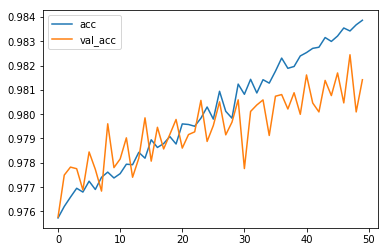

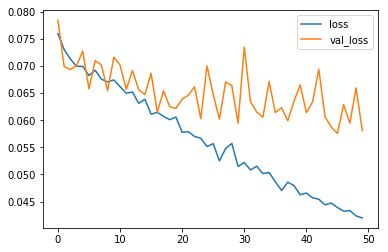

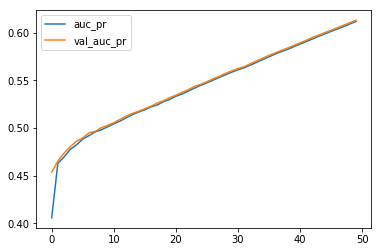

In [36]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.plot(history["acc"], label="acc")
    plt.plot(history["val_acc"], label="val_acc")
    plt.legend()
    plt.show()
    plt.close()
    
    plt.plot(history["loss"], label="loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.legend()
    plt.show()
    plt.close()

#     plt.plot(history["auc_roc"], label="auc_roc")
#     plt.plot(history["val_auc_roc"], label="val_auc_roc")

    plt.plot(history["auc_pr"], label="auc_pr")
    plt.plot(history["val_auc_pr"], label="val_auc_pr")

    plt.legend()
    plt.show()
    plt.savefig("../../logs/unet_borneo_and_harz_05_09_11_11.jpg")
    plt.close()

plot_history(history.history)

In [38]:
testGene = testGenerator("../../data/test/sat",target_size=(512,512),as_gray=False)
n = 0
for img, name in testGene:
    results = model.predict(img, batch_size=1)
    saveResult("../../data/test/predict", results, name)
    n += 1
    if(n>300):
        break

/home/ubuntu/.local/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: ../../data/test/predict/20180427_020347_103a_3B_0016.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ubuntu/.local/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: ../../data/test/predict/20180606_020625_0f1b_3B_0150.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ubuntu/.local/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: ../../data/test/predict/20180427_020501_103c_3B_0040.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ubuntu/.local/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: ../../data/test/predict/20171013_232848_0c46_3B_0040.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ubuntu/.local/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: ../../data/test/predict/20170815_005030_0c0b_3B_0068.tif is a low contrast i